# Advanced Regression Techniques

A playground competition hosted by Kaggle to test advanced regression techniques. This notebook serves as a reference for various techniques used to approach and solve regression machine learning problems.

By Wong Tran <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.figure_factory as ff
import seaborn as sns
from scipy.stats import probplot, norm, skew, ttest_ind_from_stats, t
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoLarsCV, LassoLarsIC, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from learning_curve import plot_learning_curve, compute_learning_curve
from categorical_transformer import CatTransformer
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor

<br>
<br>

# Contents

- [Initial Data Analysis](#Initial-Data-Analysis)
    - [Read in the data](#Read-in-the-data)
    - [Deal with missing data](#Deal-with-missing-data)
    - [Full missing data transformer](#Full-missing-data-transformer)
    - [Full categorical features transformer](#Full-categorical-features-transformer)
- [Exploratory Data Analysis](#Exploratory-data-analysis)
    - [Target variable](#Target-variable)
    - [Numerical features](#Numerical-features)
    - [Categorical features](#Categorical-features)
    - [Scatterplot Matrix](#Scatterplot-Matrix)
- [Linear Regression Models](#Linear-Regression-Models)
    - [Ordinary Least Squares](#Ordinary-Least-Squares)
    - [Feature selection](#Feature-selection)
        - [Sequential Feature Selection](#Sequential-Feature-Selection)
        - [Cross validated Lasso](#Cross-validated-Lasso)
        - [Random Forest Feature Importance](#Random-Forest-feature-importance)

<br>
<br>

# Initial Data Analysis

<br>
<br>

## Read in the data

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
all_data = train_df.append(test_df, sort=False)
all_data.drop('SalePrice', axis=1, inplace=True)

In [3]:
train_df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 81 entries, Id to SalePrice
dtypes: float64(3), int64(35), object(43)
memory usage: 678.7+ KB


1460/1459 entries (Train/Test)

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data fields

A brief version of what is found in the "data description" file. 

**SalePrice**: the property's sale price in dollars. This is the target variable that you're trying to predict.<br>
**MSSubClass**: The building class<br>
**MSZoning**: The general zoning classification<br>
**LotFrontage**: Linear feet of street connected to property<br>
**LotArea**: Lot size in square feet<br>
**Street**: Type of road access<br>
**Alley**: Type of alley access<br>
**LotShape**: General shape of property<br>
**LandContour**: Flatness of the property<br>
**Utilities**: Type of utilities available<br>
**LotConfig**: Lot configuration<br>
**LandSlope**: Slope of property<br>
**Neighborhood**: Physical locations within Ames city limits<br>
**Condition1**: Proximity to main road or railroad<br>
**Condition2**: Proximity to main road or railroad (if a second is present)<br>
**BldgType**: Type of dwelling<br>
**HouseStyle**: Style of dwelling<br>
**OverallQual**: Overall material and finish quality<br>
**OverallCond**: Overall condition rating<br>
**YearBuilt**: Original construction date<br>
**YearRemodAdd**: Remodel date<br>
**RoofStyle**: Type of roof<br>
**RoofMatl**: Roof material<br>
**Exterior1st**: Exterior covering on house<br>
**Exterior2nd**: Exterior covering on house (if more than one material)<br>
**MasVnrType**: Masonry veneer type<br>
**MasVnrArea**: Masonry veneer area in square feet<br>
**ExterQual**: Exterior material quality<br>
**ExterCond**: Present condition of the material on the exterior<br>
**Foundation**: Type of foundation<br>
**BsmtQual**: Height of the basement<br>
**BsmtCond**: General condition of the basement<br>
**BsmtExposure**: Walkout or garden level basement walls<br>
**BsmtFinType1**: Quality of basement finished area<br>
**BsmtFinSF1**: Type 1 finished square feet<br>
**BsmtFinType2**: Quality of second finished area (if present)<br>
**BsmtFinSF2**: Type 2 finished square feet<br>
**BsmtUnfSF**: Unfinished square feet of basement area<br>
**TotalBsmtSF**: Total square feet of basement area<br>
**Heating**: Type of heating<br>
**HeatingQC**: Heating quality and condition<br>
**CentralAir**: Central air conditioning<br>
**Electrical**: Electrical system<br>
**1stFlrSF**: First Floor square feet<br>
**2ndFlrSF**: Second floor square feet<br>
**LowQualFinSF**: Low quality finished square feet (all floors)<br>
**GrLivArea**: Above grade (ground) living area square feet<br>
**BsmtFullBath**: Basement full bathrooms<br>
**BsmtHalfBath**: Basement half bathrooms<br>
**FullBath**: Full bathrooms above grade<br>
**HalfBath**: Half baths above grade<br>
**Bedroom**: Number of bedrooms above basement level<br>
**Kitchen**: Number of kitchens<br>
**KitchenQual**: Kitchen quality<br>
**TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)<br>
**Functional**: Home functionality rating<br>
**Fireplaces**: Number of fireplaces<br>
**FireplaceQu**: Fireplace quality<br>
**GarageType**: Garage location<br>
**GarageYrBlt**: Year garage was built<br>
**GarageFinish**: Interior finish of the garage<br>
**GarageCars**: Size of garage in car capacity<br>
**GarageArea**: Size of garage in square feet<br>
**GarageQual**: Garage quality<br>
**GarageCond**: Garage condition<br>
**PavedDrive**: Paved driveway<br>
**WoodDeckSF**: Wood deck area in square feet<br>
**OpenPorchSF**: Open porch area in square feet<br>
**EnclosedPorch**: Enclosed porch area in square feet<br>
**3SsnPorch**: Three season porch area in square feet<br>
**ScreenPorch**: Screen porch area in square feet<br>
**PoolArea**: Pool area in square feet<br>
**PoolQC**: Pool quality<br>
**Fence**: Fence quality<br>
**MiscFeature**: Miscellaneous feature not covered in other categories<br>
**MiscVal**: $Value of miscellaneous feature<br>
**MoSold**: Month Sold<br>
**YrSold**: Year Sold<br>
**SaleType**: Type of sale<br>
**SaleCondition**: Condition of sale<br>

**Observations**

- The features can be generally split into three categories, those that describe the house's **structure** (e.g. OverallQual, HouseStyle), **space** (e.g.LotArea, TotalBsmtSF) or **location** (e.g. LandSlope, Neighborhood)
- There are plenty of numerical and categorical features included in the dataset. The data is likely **overspecified** with plenty of **extraneous variables**. 
- The success of this regression problem will likely be down to appropriate **feature selection** and **feature engineering**.  

<br>
<br>

## Deal with missing data

In [3]:
feats = list(all_data.columns)
missing_data_df = pd.DataFrame(all_data[feats].isnull().sum().sort_values(ascending=False))
missing_data_df.rename(columns={0:'Total'}, inplace=True)
missing_data_df['%'] = np.round(missing_data_df['Total']/len(all_data), 4)*100
missing_data_df[missing_data_df['%']!=0]

,Total,%
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageCond,159,5.45
GarageQual,159,5.45
GarageYrBlt,159,5.45
GarageFinish,159,5.45


From the data description file, most of the missing data seems to be encoded to indicate the absence of a home feature. These missing data values will be filled in with either a "None" for categorical features, or 0 for numerical features.

For features where it is not clear that missing data has been pre-encoded, our first data preprocessing iteration will just fill in these missing values with the most appropriate central value. Later we can explore more sophisticated methods of data imputation (e.g. [MICE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/)) to see if it improves the performance of our models.

<br>
<br>

## Full missing data transformer

Combine all of the missing data handling steps into a single scikit-learn style transformer and import it from a script.

In [4]:
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

In [5]:
missing_data_df = pd.DataFrame(all_data[feats].isnull().sum().sort_values(ascending=False))
missing_data_df.rename(columns={0:'Total'}, inplace=True)
missing_data_df['%'] = np.round(missing_data_df['Total']/len(all_data), 4)*100
missing_data_df[missing_data_df['%']!=0]

,Total,%
LotFrontage,486,16.65


"LotFrontage" is a numerical feature where it is not clear from the data description file whether the missing data was encoded.
Since the feature is numrical, we will leave imputation till the end to prevent information leak whilst performing cross validation.

<br>
<br>

## Full categorical features transformer

One-hot-Encode nominal categorical variables and encode ordinal categorical variables with an appropriate ordered mapping.

In [8]:
# List categorical variables
all_data.select_dtypes(include=object).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 43 columns):
MSZoning         2919 non-null object
Street           2919 non-null object
Alley            2919 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2919 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2919 non-null object
Exterior2nd      2919 non-null object
MasVnrType       2919 non-null object
ExterQual        2919 non-null object
ExterCond        2919 non-null object
Foundation       2919 non-null object
BsmtQual         2919 non-null object
BsmtCond         2919 non-null object
BsmtExposure     29

In [9]:
ordinal_feats = ["Alley", "Utilities", "LandSlope", "LotShape", "LandContour", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "PoolQC"]
nominal_feats = ["HouseStyle", "Street", "MSZoning", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "Electrical", "GarageType", "Fence", "MiscFeature", "SaleType", "SaleCondition"]

From the data description file, there appears to be some numerical features that are actually categorical, namely:

- **MSSubCLass** - Identifies the type of dwelling involved in the sale
- **MoSold** - Month Sold
- **YrSold** - Year Sold
- **OverallQual** - Rates the overall material and finish of the house
- **OverallCond** - Rates the overall condition of the house

The first three are nominal categorical variables that have been pre-encoded to numerical values. These numerical values need to be treated as strings and one-hot encoded along with the rest of the nominal categorical features. 

OverallQual and OverallCond are ordinal and are already encoded in numerical format thus no mapping will be required.

We will again combine the categorical feature encoding steps into a single scikit-learn style transformer and import it from a separate script

In [10]:
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 230 entries, Id to YrSold_2010
dtypes: float64(11), int64(44), uint8(175)
memory usage: 1.7 MB


In [12]:
len(cat_transf.all_feature_names)

230

After transforming all of the categorical variables, we have 230 features in total. 

<br>
<br>

# Exploratory data analysis

To perform EDA, we'll look at the training dataset after imputing missing values but without transforming categorical variables.

In [5]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]

In [6]:
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
train_df = missing_imputer.fit_transform(train_df)

<br>
<br>

## Target variable

Check normality of the target variable.

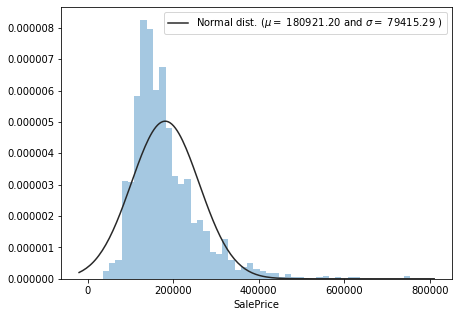

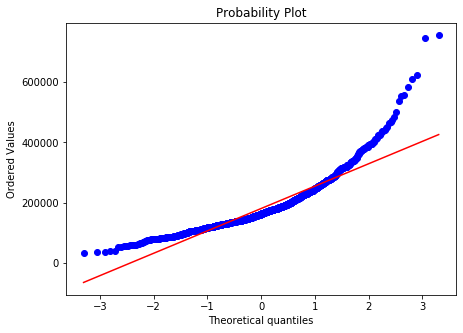

In [16]:
plt.figure(figsize=(7,5))
(mu,sigma) = norm.fit(train_labels['SalePrice'])
sns.distplot(train_labels['SalePrice'], fit=norm, kde=False)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

plt.figure(figsize=(7,5))
probplot(train_labels['SalePrice'], plot=plt)
plt.show()

This normal probability plot indicates that the target variable is right skewed. SalePrice is bounded below at 0 and there are many houses which sell for a large amount.

Target variable transformations may have to be used to maintain the assumptions of a regression model but we will investigate this when evaluating our model.

<br>
<br>

## Numerical features

A good way to quickly visualise the linear associations and potential collinearity between all numerical features is a heatmap of correlations

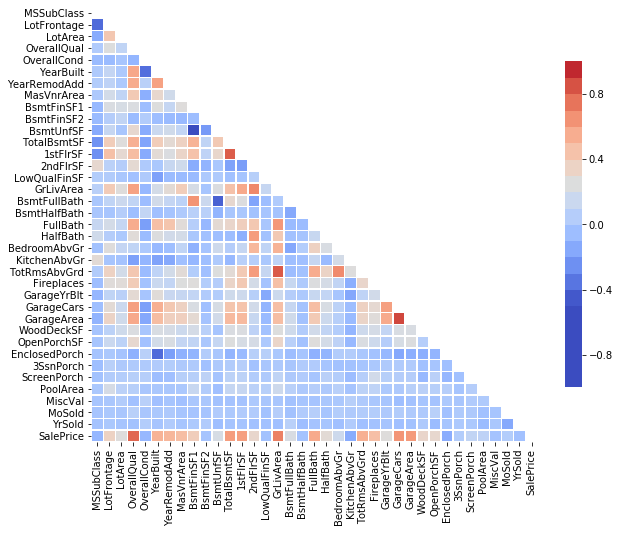

In [17]:
mask = np.zeros_like(train_df.iloc[:,1:].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,8));
sns.heatmap(train_df.iloc[:,1:].corr(), linewidths=0.5, cmap='coolwarm', mask=mask,
            cbar_kws={'boundaries':np.linspace(-1,1, 21).tolist(),
                      'shrink':0.75});

**Observations**:

- There appears to be strong collinearity between 'GarageArea' and 'GarageCars' as well as between 'TotRmsAbvGrd' and 'GrLivArea', which makes sense as they are features which are linked and provide almost the same information. Pruning these features may be required to produce a more stable and interpretable model.
- Other features that are correlated include those that provide information about the size of a home as well as features that give information about the homes' capacity, for instance, the link between '1stFlrSF', 2ndFlrSf', 'GarageArea' etc.
- From the bottom rows, there appears to be several numerical features with a strong positive correlation with the target variable, particularly 'OverallQual', 'GrLivArea' as well as several indicators of a home's size.

<br>
<br>

## Categorical features

A feature that stands out from the correlation plot is "OverallQual" which appears to have a strong correlation with the target variable. Since it's an ordinal categorical variable, let's visualize this with a boxplot.

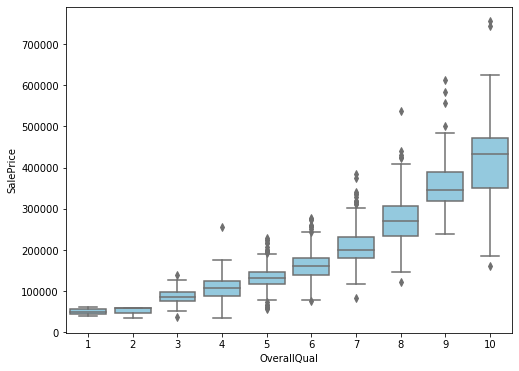

In [18]:
plt.figure(figsize=(8,6))
sns.boxplot(train_df['OverallQual'], train_df['SalePrice'], color='skyblue')

A strong positive correlation exists between 'OverallQual' (the overall material and finish of the house) and its sale price which seems pretty intuitive. The relationship doesn't seem to be linear and is heteroscedastic 

<br>
<br>

Let's visualize the relationship between the year a house was built and its Sale Price

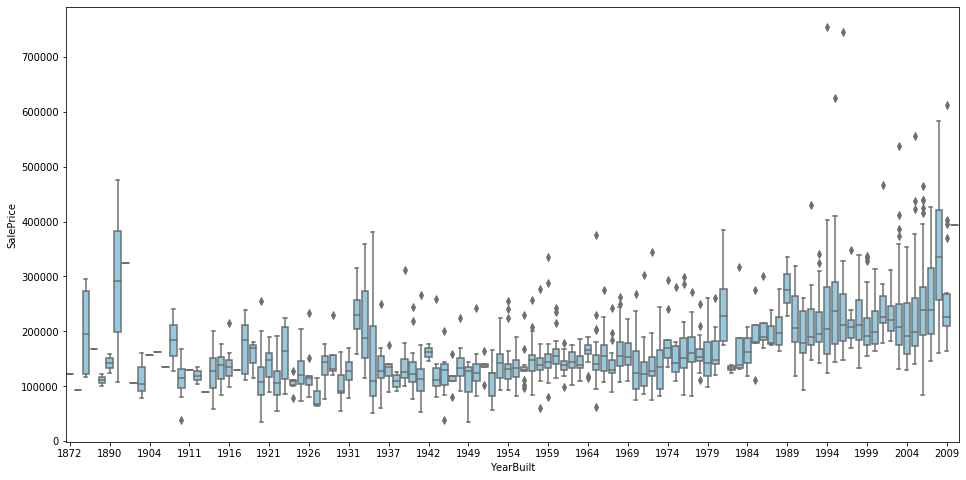

In [19]:
plt.figure(figsize=(16,8))
sns.boxplot(x='YearBuilt', y='SalePrice', data=train_df, color='skyblue')
loc, label = plt.xticks()
plt.xticks(loc[::5], label[::5]);

Although there are plenty of exceptions, in general, modern houses (e.g. those built within the last two decades of the dataset) sell for more.
We can easily verify this by checking the median sale price for two time periods.

In [20]:
print("Median sale price of homes built from 1989 onwards: ${}".format(train_df[train_df['YearBuilt']>=1989].SalePrice.median()))
print("Median sale price of homes built before 1989: ${}".format(train_df[train_df['YearBuilt']<1989].SalePrice.median()))

Median sale price of homes built from 1989 onwards: $215600.0
Median sale price of homes built before 1989: $137950.0


**Two-tailed difference of two means t-test**

In [19]:
ttest_ind_from_stats(mean1=train_df[train_df['YearBuilt']>=1989].SalePrice.mean(), 
                     std1=train_df[train_df['YearBuilt']>=1989].SalePrice.std(ddof=1), 
                     nobs1=len(train_df[train_df['YearBuilt']>=1989]), 
                     mean2=train_df[train_df['YearBuilt']<1989].SalePrice.mean(), 
                     std2=train_df[train_df['YearBuilt']<1989].SalePrice.std(ddof=1), 
                     nobs2=len(train_df[train_df['YearBuilt']<1989]), 
                     equal_var=False)

Ttest_indResult(statistic=23.303598658604265, pvalue=1.1541766399276009e-91)

The p-value is statistically significant at $\alpha=0.05$ significance level. The mean sale price of houses built before 1989 is statistically different and less than the mean sale price of houses built after 1989

<br>
<br>

Let's see if there is any seasonality in the relationship between the sale month of homes and their sale price 

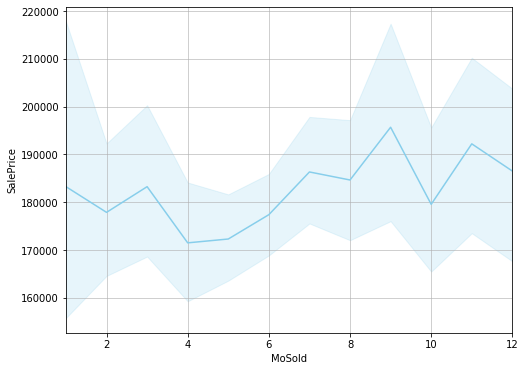

In [21]:
plt.figure(figsize=(8,6))
sns.lineplot(x='MoSold', y='SalePrice', data=train_df, color='skyblue', 
             estimator='mean', ci=95) # 1-sigma
plt.grid(alpha=0.75)
plt.xlim(1,12);

There is large variability in the sale price of homes with respect to the month it was sold, however, the first half of the year (Q1, Q2) seems to have slightly lower home sale prices compared to the second half (Q3, Q4). Let's verify this. 

In [22]:
print("Q1 and Q2 median home sale prices: ${}".format(train_df.loc[train_df['MoSold']<7].SalePrice.median()))
print("Q3 and Q4 median home sale prices: ${}".format(train_df.loc[train_df['MoSold']>=7].SalePrice.median()))

Q1 and Q2 median home sale prices: $158950.0
Q3 and Q4 median home sale prices: $170000.0


**Two-tailed difference of two means t-test**

In [21]:
from scipy.stats import ttest_ind_from_stats, t
ttest_ind_from_stats(mean1=train_df.loc[train_df['MoSold']<7].SalePrice.mean(), 
                     std1=train_df.loc[train_df['MoSold']<7].SalePrice.std(ddof=1), 
                     nobs1=len(train_df.loc[train_df['MoSold']<7]), 
                     mean2=train_df.loc[train_df['MoSold']>=7].SalePrice.mean(), 
                     std2=train_df.loc[train_df['MoSold']>=7].SalePrice.std(ddof=1), 
                     nobs2=len(train_df.loc[train_df['MoSold']>=7]), 
                     equal_var=False)

Ttest_indResult(statistic=-2.47298419419772, pvalue=0.01352266431182276)

The p-value is statistically significant at $\alpha=0.05$ significance level. The mean sale price of houses sold during the first half of the year is statistically different and less than the mean sale price of houses sold during the second half of the year.

<br>
<br>

## Scatterplot Matrix

Since there are too many numerical variables to visualize all at once, let's make a scatterplot matrix (pairplot) of numerical features that have a correlation greater than 0.5 between them and the target variable.

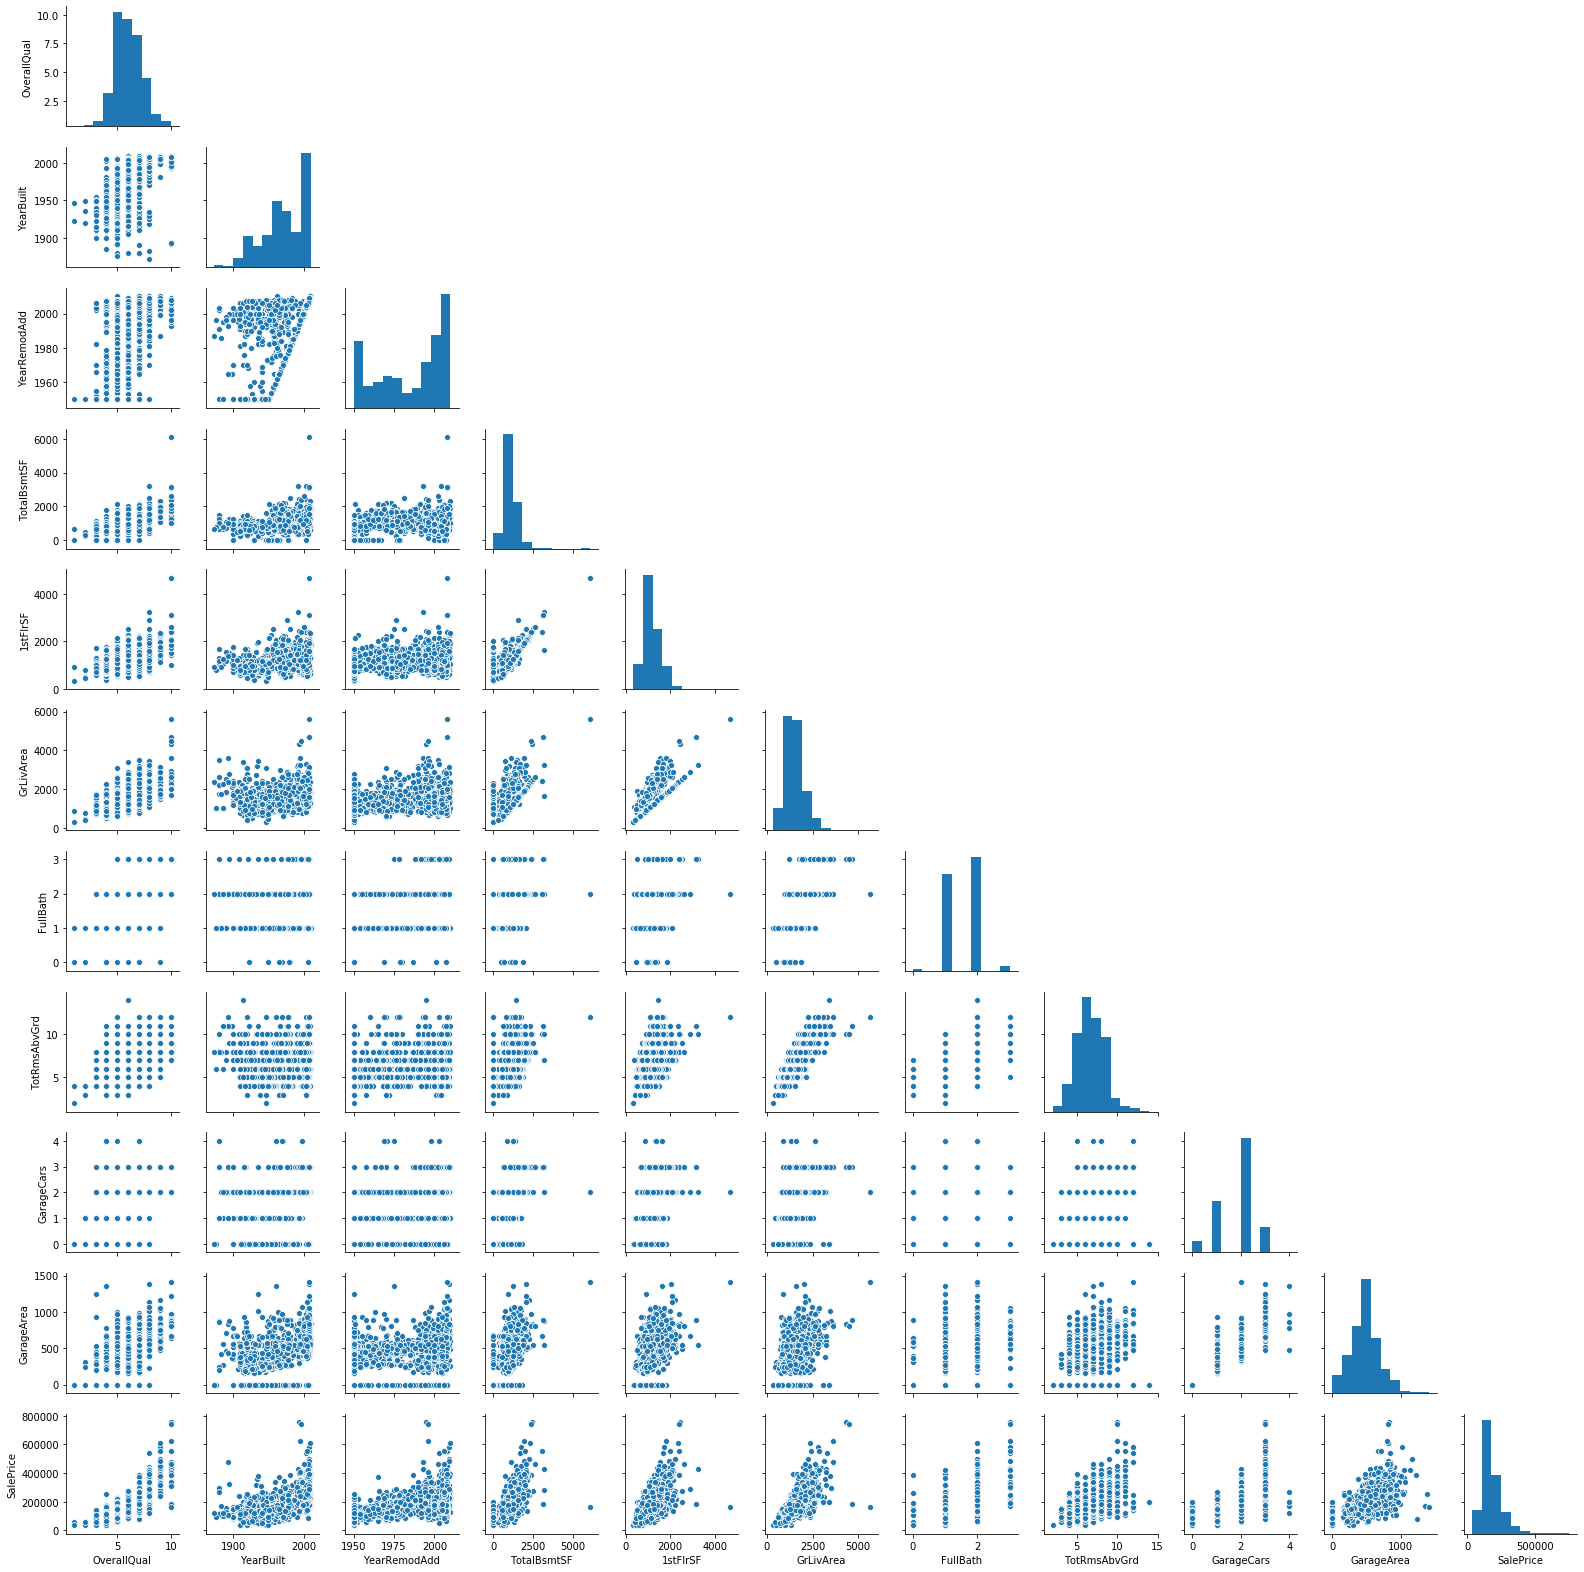

In [23]:
corr_saleprice = np.abs(train_df.corr()['SalePrice'])
feats05greater = corr_saleprice[corr_saleprice>0.5].index

g = sns.pairplot(train_df.loc[:,feats05greater], height=2)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
    
del(corr_saleprice)

Observations:

- The best numerical predictors of sale price are features that tell us information about the home's size, the number of rooms they have as well as the year they were built/remodelled. 

<br>
<br>

# Linear Regression Models

In [2]:
# Import data

train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_labels = train_df[['Id','SalePrice']]
test_id = pd.DataFrame(test_df['Id'])
all_data = train_df.append(test_df, sort=False)
all_data.drop(columns='SalePrice', inplace=True)

# Impute missing values (excluding LotFrontage)
from missing_data import MissingDataImputer
missing_imputer = MissingDataImputer()
all_data = missing_imputer.fit_transform(all_data)

# Transform categorical variables
from categorical_transformer import CatTransformer
cat_transf = CatTransformer()
all_data = cat_transf.fit_transform(all_data)

# Create LotFrontage imputer
lotfrontage_imputer = MissingDataImputer(impute_lotfrontage=True)

train_df = all_data[all_data['Id'].isin(train_df['Id'])]
test_df = all_data[all_data['Id'].isin(test_df['Id'])]

train_df.drop(columns='Id', inplace=True)
test_df.drop(columns='Id', inplace=True)

<br>
<br>

## Ordinary Least Squares

In [3]:
train_df = SimpleImputer(strategy='median').fit_transform(train_df)
X_train_with_bias = sm.add_constant(train_df)  # Add feature of ones 
lin_regr = sm.OLS(train_labels['SalePrice'].values, X_train_with_bias).fit()

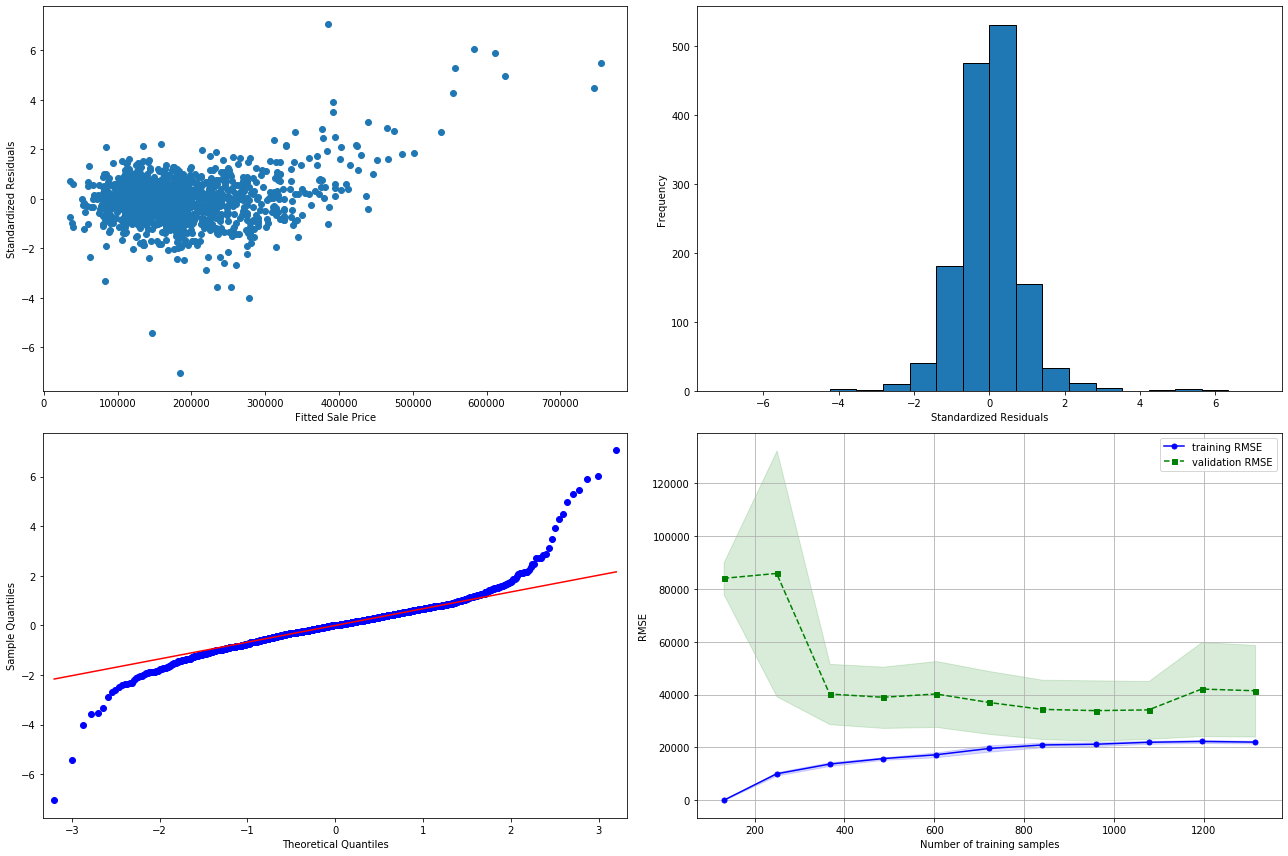

In [6]:
fig=plt.figure(figsize=(18,12))

ax1 = plt.subplot(221)
ax1.scatter(train_labels['SalePrice'].values, lin_regr.resid_pearson)
ax1.set_xlabel("Fitted Sale Price")
ax1.set_ylabel("Standardized Residuals")

ax2 = plt.subplot(222)
ax2.hist(lin_regr.resid_pearson, bins=20, edgecolor='k')
ax2.set_xlabel("Standardized Residuals")
ax2.set_ylabel("Frequency")

ax3 = plt.subplot(223)
fig = sm.qqplot(lin_regr.resid_pearson, line='q', ax=ax3)

ax4 = plt.subplot(224)
lin_regr_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('lin_regr', LinearRegression())])
lin_regr_pipe.fit(train_df, train_labels['SalePrice'])

lc_params = compute_learning_curve(estimator=lin_regr_pipe, 
                                X=train_df, 
                                y=train_labels['SalePrice'].values,
                                cv=10)
plot_learning_curve(ax4, lc_params)
plt.tight_layout()

**Observations**

- According to the $R^2$ there is a strong linear relationship between the features and the response, ~92.0% of the variation in SalePrice is explained by the features.
- The residual plot shows a departure from linearity for high values of "SalePrice", indicating that a non-linear fit would be better. As a result of the non-linearity it is difficult to tell if the model is affected by heteroscedasticity
- The normal probability plot for the residuals indicate departure from normality in the high and low quartiles. The normality plot is indicative of a heavy-tailed distribution as can be seen in the histogram of residuals
- The learning curve shows that the model is performing better on the training set compared to the validation set which is an indication of overfitting. There is a bump in validation RMSE at around 1100 training samples, as a result it is not clear whether more data would improve the model.

In [6]:
vif_dict = {}
for idx, feat in enumerate(train_df.columns):
    vif_dict[feat] = variance_inflation_factor(X_train_with_bias, idx+1);
vif_series = pd.Series(vif_dict)
del(vif_dict)

c:\users\wongt\desktop\advanced_regression_techniques_conda\venv\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning:

divide by zero encountered in double_scalars

c:\users\wongt\desktop\advanced_regression_techniques_conda\venv\lib\site-packages\statsmodels\regression\linear_model.py:1636: RuntimeWarning:

invalid value encountered in double_scalars



In [8]:
vif_series.sort_values(ascending=False).head(30)

Exterior2nd_CBlock             inf
GrLivArea                      inf
LowQualFinSF                   inf
2ndFlrSF                       inf
BldgType_Duplex                inf
1stFlrSF                       inf
TotalBsmtSF                    inf
Exterior1st_CBlock             inf
BsmtUnfSF                      inf
BsmtFinSF2                     inf
BsmtFinSF1                     inf
MSSubClass_90                  inf
GarageYrBlt            2148.049979
GarageType_None        1994.406296
MiscFeature_None        967.664861
MiscFeature_Shed        807.269052
RoofStyle_Gable         159.439915
RoofStyle_Hip           147.939037
MSSubClass_20           139.645322
MSSubClass_60           121.934431
Exterior1st_VinylSd     113.648035
Exterior2nd_VinylSd     104.144515
GarageType_Attchd        81.433388
Exterior1st_MetalSd      75.306730
MSSubClass_50            70.899255
Exterior2nd_MetalSd      69.369170
GarageType_Detchd        65.309908
Exterior1st_HdBoard      58.618184
HouseStyle_1Story   

Since there are many features, most of which have a high VIF (>15), we must perform variable selection to reduce the number of features before attempting any non-linear regression methods. This is to mitigate the possibility of overfitting when introducing non-linear and interaction features.

<br>
<br>

## Feature selection

<br>
<br>

### Sequential Feature Selection

In [ ]:
feat_names = list(train_df.columns)
sfs_pipe = Pipeline([('lotfront_imp', SimpleImputer(strategy='median')),
                       ('lin_regr', LinearRegression()),
                      ])

sfs = SFS(sfs_pipe, 
          k_features='parsimonious', 
          forward=True, 
          floating=True, 
          verbose=2,
          scoring='neg_mean_squared_error',
          cv=5,
          n_jobs=4
         )

sfs = sfs.fit(train_df.values, train_labels['SalePrice'], custom_feature_names=feat_names)

In [56]:
print("Parsimonious SFS:\n")
print("{} features chosen by SFS\n".format(len(sfs.k_feature_names_)))
print("Selected features: {}\n".format(sfs.k_feature_names_))
print("Best score: {}".format(np.sqrt(-sfs.k_score_)))

Parsimonious SFS:

29 features chosen by SFS

Selected features: ('LotArea', 'OverallQual', 'OverallCond', 'GrLivArea', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'ExterQual', 'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'Functional', 'HouseStyle_2Story', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Condition1_Norm', 'RoofStyle_Hip', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace', 'GarageType_None', 'SaleType_New', 'MSSubClass_20', 'MSSubClass_60')

Best score: 30338.49583463479


In [10]:
sfs_scores = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_scores.to_csv("data/sfs_df.csv", index=False)  # Save the SFS results
sfs_scores['RMSE'] = (-sfs_scores['avg_score'])**0.5

In [42]:
sfs_scores.sort_values('avg_score', ascending=False).head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,RMSE
84,"(1, 2, 3, 4, 9, 14, 15, 16, 17, 18, 19, 20, 21...","[-440678879.17026794, -889771180.8025004, -826...",-8.61737e+08,"(LotArea, OverallQual, OverallCond, YearBuilt,...",4.48135e+08,3.48664e+08,1.74332e+08,29355.4
85,"(1, 2, 3, 4, 9, 14, 15, 16, 17, 18, 19, 20, 21...","[-440678879.170296, -889771180.8026042, -82671...",-8.61737e+08,"(LotArea, OverallQual, OverallCond, YearBuilt,...",4.48135e+08,3.48664e+08,1.74332e+08,29355.4
86,"(1, 2, 3, 4, 9, 14, 15, 16, 17, 18, 19, 20, 21...","[-440678879.17023355, -890241337.8664689, -826...",-8.61766e+08,"(LotArea, OverallQual, OverallCond, YearBuilt,...",4.48159e+08,3.48683e+08,1.74341e+08,29355.9
87,"(1, 2, 3, 4, 9, 14, 15, 16, 17, 18, 19, 20, 21...","[-438335085.86457294, -888579457.4638133, -827...",-8.61799e+08,"(LotArea, OverallQual, OverallCond, YearBuilt,...",4.47118e+08,3.47873e+08,1.73937e+08,29356.4
88,"(1, 2, 3, 4, 9, 14, 15, 16, 17, 18, 19, 20, 21...","[-438335085.86455476, -889121987.4611645, -826...",-8.61836e+08,"(LotArea, OverallQual, OverallCond, YearBuilt,...",4.47075e+08,3.47839e+08,1.7392e+08,29357


Chosen parsimonious model

In [41]:
sfs_scores[sfs_scores['avg_score']==sfs.k_score_]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,RMSE
29,"(1, 2, 3, 14, 22, 24, 26, 30, 38, 42, 43, 46, ...","[-498090438.6093986, -978074034.8905374, -9275...",-9.20424e+08,"(LotArea, OverallQual, OverallCond, GrLivArea,...",4.00323e+08,3.11465e+08,1.55733e+08,30338.5


<br>
<br>

### Cross validated Lasso

The same optimal regularization parameter $\alpha$ can be obtained much more efficiently using `LassoCV` or `LassoLarsCV` which is done by directly modifying the optimization method instead of using a grid search wrapper. I still use the wrapper method below for illustrative purposes in order to obtain a good visualization of the optimization path. 

In [138]:
lasso_pipe = Pipeline([('lotfront_imp', SimpleImputer(strategy='median')),
                       ('scale', StandardScaler()),
                       ('lasso', Lasso(max_iter=10000)),
                      ])
lasso_gs = GridSearchCV(lasso_pipe,
                        {'lasso__alpha':np.logspace(2,4, 201)},
                        'neg_mean_squared_error',
                        n_jobs=4,
                        iid=False,
                        cv=10,
                       )
best_lasso = lasso_gs.fit(train_df.values, train_labels['SalePrice'])
lasso_cv_scores = pd.DataFrame(best_lasso.cv_results_)

Best param: {'lasso__alpha': 831.7637711026708}
Best MSE: -1093099432.434754
Best RMSE: 33062.05426822045


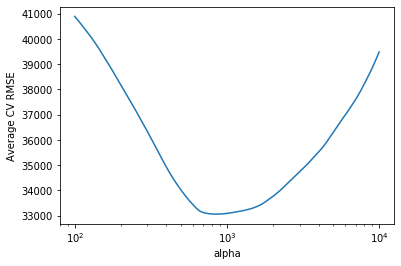

In [139]:
print("Best param:",best_lasso.best_params_)
print("Best MSE:",best_lasso.best_score_)
print("Best RMSE:",np.sqrt(-best_lasso.best_score_))

alpha = lasso_cv_scores.param_lasso__alpha.values
cv_score = lasso_cv_scores.mean_test_score.values

plt.yscale("linear")
plt.xscale("log")
plt.plot(alpha, np.sqrt(-cv_score))
plt.xlabel("alpha")
plt.ylabel("Average CV RMSE");

In [140]:
feat_names = list(train_df.columns)
lasso_coefs = sorted(list(zip(feat_names, best_lasso.best_estimator_.named_steps['lasso'].coef_)), 
               key=lambda x: x[1], 
               reverse=True)
print("{} features chosen by Lasso".format(np.sum(best_lasso.best_estimator_.named_steps['lasso'].coef_!=0)))
print([feat[0] for feat in lasso_coefs if feat[1]!=0])

81 features chosen by Lasso
['GrLivArea', 'OverallQual', 'Neighborhood_NridgHt', 'GarageCars', 'Neighborhood_NoRidge', 'BsmtExposure', 'Neighborhood_StoneBr', 'RoofMatl_WdShngl', 'KitchenQual', 'SaleType_New', 'ExterQual', 'MasVnrArea', 'OverallCond', 'BsmtQual', 'Neighborhood_Crawfor', 'MSSubClass_20', 'BsmtFinSF1', 'YearBuilt', 'BsmtFinType1', 'LotArea', 'LotConfig_CulDSac', 'Fireplaces', 'TotRmsAbvGrd', 'FullBath', 'HouseStyle_1Story', 'RoofMatl_CompShg', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Neighborhood_Somerst', 'Exterior1st_CemntBd', 'BsmtFullBath', 'ScreenPorch', 'Neighborhood_BrkSide', 'WoodDeckSF', 'Exterior2nd_ImStucc', 'GarageType_None', 'HalfBath', 'HeatingQC', 'Foundation_Slab', 'SaleType_Con', 'Neighborhood_Veenker', 'Utilities', 'MoSold_7', 'MoSold_5', 'RoofMatl_Membran', 'Street_Pave', 'GarageFinish', 'Condition2_PosA', 'LandSlope', 'GarageType_BuiltIn', 'Foundation_PConc', 'YearRemodAdd', 'FireplaceQu', '3SsnPorch', 'Exterior1st_ImStucc', 'LowQualFinSF', 'SaleCon

**`LassoCV` gives approximately the same optimal $\alpha$ and chooses the same features**

In [147]:
lassocv_pipe = Pipeline([('lotfront_imp', SimpleImputer(strategy='median')),
                         ('scale', StandardScaler()),
                         ('Lasso', LassoCV(max_iter=10000, normalize=False, cv=10, n_jobs=4)),
                        ])
lassocv_pipe.fit(train_df.values, train_labels['SalePrice'].values)
lassocv_pipe.named_steps['Lasso'].alpha_

830.3910103604513

In [148]:
feat_names = list(train_df.columns)
lassocv_coefs = sorted(list(zip(feat_names, lassocv_pipe.named_steps['Lasso'].coef_)), 
                       key=lambda x: x[1], 
                       reverse=True)
print([feat[0] for feat in lassocv_coefs if feat[1]!=0])

['GrLivArea', 'OverallQual', 'Neighborhood_NridgHt', 'GarageCars', 'Neighborhood_NoRidge', 'BsmtExposure', 'Neighborhood_StoneBr', 'RoofMatl_WdShngl', 'KitchenQual', 'SaleType_New', 'ExterQual', 'MasVnrArea', 'OverallCond', 'BsmtQual', 'Neighborhood_Crawfor', 'MSSubClass_20', 'BsmtFinSF1', 'YearBuilt', 'BsmtFinType1', 'LotArea', 'LotConfig_CulDSac', 'Fireplaces', 'TotRmsAbvGrd', 'HouseStyle_1Story', 'FullBath', 'RoofMatl_CompShg', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Neighborhood_Somerst', 'Exterior1st_CemntBd', 'BsmtFullBath', 'ScreenPorch', 'Neighborhood_BrkSide', 'WoodDeckSF', 'Exterior2nd_ImStucc', 'GarageType_None', 'HalfBath', 'HeatingQC', 'Foundation_Slab', 'SaleType_Con', 'Neighborhood_Veenker', 'Utilities', 'MoSold_7', 'MoSold_5', 'RoofMatl_Membran', 'Street_Pave', 'GarageFinish', 'Condition2_PosA', 'LandSlope', 'GarageType_BuiltIn', 'Foundation_PConc', 'YearRemodAdd', 'FireplaceQu', '3SsnPorch', 'Exterior1st_ImStucc', 'LowQualFinSF', 'SaleCondition_Family', 'Condition1_

In [149]:
set([feat[0] for feat in lasso_coefs if feat[1]!=0]) ^ set([feat[0] for feat in lassocv_coefs if feat[1]!=0])

set()

**`LassoLarsCV` gives approximately the same optimal $\alpha$ and chooses approximately the same features**

In [150]:
lassolarscv_pipe = Pipeline([('lotfront_imp', SimpleImputer(strategy='median')),
                             ('scale', StandardScaler()),
                             ('LassoLars', LassoLarsCV(max_iter=10000, normalize=False, cv=10, n_jobs=4)),
                            ])
lassolarscv_pipe.fit(train_df.values, train_labels['SalePrice'].values)
lassolarscv_pipe.named_steps['LassoLars'].alpha_

851.0084094948371

In [151]:
feat_names = list(train_df.columns)
lassolarscv_coefs = sorted(list(zip(feat_names, lassolarscv_pipe.named_steps['LassoLars'].coef_)), 
               key=lambda x: x[1], 
               reverse=True)
print([feat[0] for feat in lassolarscv_coefs if feat[1]!=0])

['GrLivArea', 'OverallQual', 'Neighborhood_NridgHt', 'GarageCars', 'Neighborhood_NoRidge', 'BsmtExposure', 'Neighborhood_StoneBr', 'RoofMatl_WdShngl', 'KitchenQual', 'SaleType_New', 'ExterQual', 'MasVnrArea', 'OverallCond', 'BsmtQual', 'MSSubClass_20', 'Neighborhood_Crawfor', 'BsmtFinSF1', 'YearBuilt', 'BsmtFinType1', 'LotArea', 'LotConfig_CulDSac', 'Fireplaces', 'FullBath', 'TotRmsAbvGrd', 'HouseStyle_1Story', 'RoofMatl_CompShg', 'Condition1_Norm', 'Exterior1st_BrkFace', 'Neighborhood_Somerst', 'Exterior1st_CemntBd', 'BsmtFullBath', 'ScreenPorch', 'Neighborhood_BrkSide', 'WoodDeckSF', 'Exterior2nd_ImStucc', 'GarageType_None', 'HeatingQC', 'HalfBath', 'Foundation_Slab', 'SaleType_Con', 'Neighborhood_Veenker', 'MoSold_7', 'Utilities', 'MoSold_5', 'RoofMatl_Membran', 'Street_Pave', 'GarageFinish', 'Condition2_PosA', 'LandSlope', 'GarageType_BuiltIn', 'Foundation_PConc', 'YearRemodAdd', 'FireplaceQu', 'Exterior1st_ImStucc', 'LowQualFinSF', 'SaleCondition_Family', 'LotConfig_FR3', 'Conditi

In [152]:
set([feat[0] for feat in lasso_coefs if feat[1]!=0]) ^ set([feat[0] for feat in lassolarscv_coefs if feat[1]!=0])

{'3SsnPorch'}

<br>
<br>

### Random Forest feature importance

With the help of the `RFECV` wrapper, we can iteratively prune features using the Random Forest `feature_importances_` attribute. Important features are those that when split on results in a large impurity decrease when averaged over all of the decision trees in the forest.

In [ ]:
train_df_copy = SimpleImputer(strategy='median').fit_transform(train_df)
rand_for = RandomForestRegressor(n_estimators=1000, n_jobs=4, max_features='sqrt')
selector = RFECV(rand_for, step=1, cv=5, n_jobs=2, scoring='neg_mean_squared_error', verbose=1)
selector = selector.fit(train_df_copy, train_labels['SalePrice'])

In [34]:
feat_names = np.array(train_df.columns)
print("{} features selected\n".format(selector.n_features_))
print(list(feat_names[selector.support_]),"\n")
print("Random Forest best RMSE: {}".format(np.sqrt(-selector.grid_scores_[37])))

38 features selected

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'HouseStyle_2Story', 'Neighborhood_NoRidge', 'Foundation_PConc', 'GarageType_Attchd', 'MSSubClass_60'] 

Random Forest best RMSE: 28782.81928525163


<br>
<br>

**Other feature selection techniques:**

- **Lasso Lars IC** - Perform the Lasso feature selection using an Information Criterion rather than directly using the evaluation metric (MSE). This should result in a different set of features 
    - Gives errors when tried
- **RFECV using `coef_`** - Recursive feature elimination using the magnitude of regression coefficient values as an indicator of feature importance (unimportant features are pruned first)
    - Relies on using the magnitude of coefficients in an additive model as an indicator of feature importance which is sensitive to the scale of features without normalization. We avoid normalization to retain model interpretability
- **PLS & PCR** - Selects linear combination of features that either retain a certain level of feature variance (PCA) or finds directions in the linear subspace that are most correlated with the response (PCR).
    - These methods are not used in an attempt to retain model interpretability as producing linear combinations of features results in a feature set that is not immediately interpretable

<br>
<br>

# Regression Workflow

Before EDA

- Fill in missing data:
    - see [types of missing data](https://www.displayr.com/different-types-of-missing-data/)
    - Handle MNAR entries (fill in with appropriate value e.g. None or 0)
    - Impute MAR entries (central tendency, MICE, KNN etc) See [fancyimpute](https://github.com/iskandr/fancyimpute)
- Transform Categorical variables
    - Ordinal mappings for ordinal categorical variables or Dummy encoding for nominal categorical variables
    - For high cardinality categorical variables see [categorical encoders](https://github.com/scikit-learn-contrib/categorical-encoding)
    
EDA

- Check response:
    - Is it normally distributed? bounded below? skewed?
    - A transformation might help the problems above
    - A GLM might be appropriate for bounded and skewed responses
- Check numerical variables
    - Correlation heatmap
    - Scatterplot matrix for highly correlated (with response) features
    - etc
- Check categorical variables
    - Ordered Boxplots
    - Barcharts
    - etc

First model

- Check and assess [model assumptions](https://newonlinecourses.science.psu.edu/stat501/node/317/)
- Determine next steps from the initial model
    - if features need to be pruned, perform feature selection
    - if non-linearity exists, explore hard fitting models
    - if heteroscedasticity is present, explore response and/or feature transformations or GLMs
    - if autocorrelation exists, explore time-series methods

Subsequent models

- After identifying useful features using feature selection:
    - Produce residual plot against remaining (or engineered) predictors to identify any potential useful predictors to be added
- Perform feature engineering (interactions + non-linear features) using the reduced set of features
- Try ML models with high predictive power:
    - GAM
    - Random Forest
    - GBDT
    - XGBoost, LightGBM, Catboost
- Run more sophisticated models to check the performance deficit between interpretable models and hard-fitting models
    
Conclusion

- Evaluate interpretable models (OLSR, GLM) by [visualizing the coefficients](https://christophm.github.io/interpretable-ml-book/limo.html)
- Perform inference on interpretable models:
    - Check p-values of coefficients
    - Perform sequential sum of squares F-test on nested models where applicable (e.g. on dropped high p-value features)
- Identify important features and produce useful predictions
    - For features with high coefficient values, interpret the coefficients
    - Check prediciton intervals for practically (and statistically) significant changes to the response when varying a certain important features
- Evaluate uninterpretable models using [model-agnostic interpretation methods](https://christophm.github.io/interpretable-ml-book/agnostic.html)

# To do

- ~~FIX N_JOBS - STILL BROKEN, use Conda environment~~
- ~~Run SFS (understand the floating one?)~~
- ~~Run LassoLarsCV, LassoLarsIc, LarsPath etc.~~
- ~~Run Random Forest feature selection~~
- ~~Change OLSR evaluation to a subplot and fix the code~~
- ~~Seq Sum of Sqs test after removing SFS or Lasso features (May not work due to feature names)~~
- Read up on the next logical step to deal with non linearity (is polynomial features the next step??)
- Read up on lognormal glm
- Use reduced features to produce non-linear model
- Deal with skewed features with transforms
- GLM (lognormal?)